In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sp500csv = pd.read_csv("data_Q2.csv", sep=";")

sp500csv["Date"] = pd.to_datetime(sp500csv["Date"])

# Vraag 2A
vti = sp500csv[sp500csv["ticker"] == "VTI"].copy()
tlt = sp500csv[sp500csv["ticker"] == "TLT"].copy()


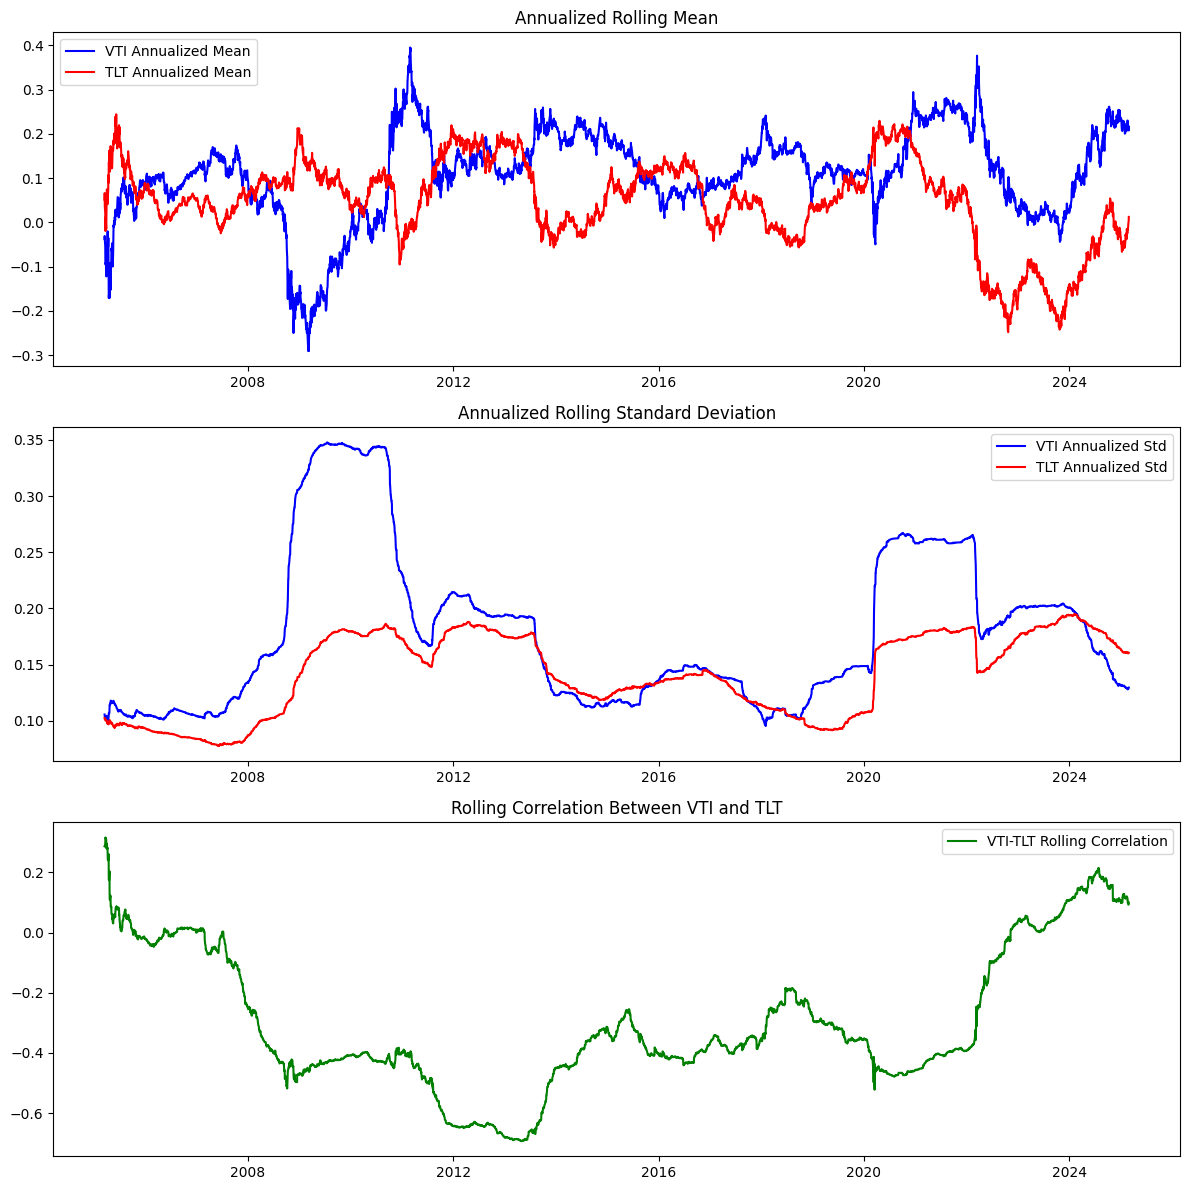

        Date  Return_VTI  Rolling_Std_VTI  Return_TLT  Rolling_Std_TLT  \
0 2005-01-03         NaN              NaN         NaN              NaN   
1 2005-01-04   -0.013311              NaN   -0.010480              NaN   
2 2005-01-05   -0.006918              NaN    0.005351              NaN   
3 2005-01-06    0.004789              NaN    0.000680              NaN   
4 2005-01-07   -0.003206              NaN    0.002264              NaN   

   Rolling_Corr  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  


In [12]:

vti.loc[:, "Return"] = vti["Adj Close"].pct_change()
tlt.loc[:, "Return"] = tlt["Adj Close"].pct_change()

# Vraag 2B
# neem minimale periode van de eerste 50 observaties anders krijg je rare jumps in de eerste observaties wat de grafiek onduidelijk maakt.
vti.loc[:, "Rolling_Mean"] = vti["Return"].rolling(window=500, min_periods=50).mean()
vti.loc[:, "Rolling_Std"] = vti["Return"].rolling(window=500, min_periods=50).std()
tlt.loc[:, "Rolling_Mean"] = tlt["Return"].rolling(window=500, min_periods=50).mean()
tlt.loc[:, "Rolling_Std"] = tlt["Return"].rolling(window=500, min_periods=50).std()

vti.loc[:, "Annualized_Mean"] = vti["Rolling_Mean"] * 252
vti.loc[:, "Annualized_Std"] = vti["Rolling_Std"] * np.sqrt(252)

tlt.loc[:, "Annualized_Mean"] = tlt["Rolling_Mean"] * 252
tlt.loc[:, "Annualized_Std"] = tlt["Rolling_Std"] * np.sqrt(252)

# Maak een return dataframe voor de volgende code blok
returns_df = pd.merge(vti[["Date", "Return", "Rolling_Std"]],
                      tlt[["Date", "Return", "Rolling_Std"]],
                      on="Date", suffixes=("_VTI", "_TLT"))

returns_df.loc[:, "Rolling_Corr"] = returns_df["Return_VTI"].rolling(window=500, min_periods=50).corr(returns_df["Return_TLT"])

# print(vti["Annualized_Mean"].to_latex())

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

axes[0].plot(vti["Date"], vti["Annualized_Mean"], label="VTI Annualized Mean", color="blue")
axes[0].plot(tlt["Date"], tlt["Annualized_Mean"], label="TLT Annualized Mean", color="red")
axes[0].set_title("Annualized Rolling Mean")
axes[0].legend()

axes[1].plot(vti["Date"], vti["Annualized_Std"], label="VTI Annualized Std", color="blue")
axes[1].plot(tlt["Date"], tlt["Annualized_Std"], label="TLT Annualized Std", color="red")
axes[1].set_title("Annualized Rolling Standard Deviation")
axes[1].legend()

axes[2].plot(returns_df["Date"], returns_df["Rolling_Corr"], label="VTI-TLT Rolling Correlation", color="green")
axes[2].set_title("Rolling Correlation Between VTI and TLT")
axes[2].legend()

plt.tight_layout()
plt.show()
# print(vti.head())
# print(tlt.head())
print(returns_df.head())


# Vraag 2D
We zien dat de time serie van de aandelen ETF significant meer volatiel is dan de time series van de 20 year treasury bonds. Dit komt door de grotere variatie in het gemiddelde en de constant hogere standaardeviatie (zie bovenstaande grafieken).

        Date  Parity_Return  Tangency_Return  Min_Variance_Return  \
0 2005-01-03            NaN              NaN                  NaN   
1 2005-01-04      -0.011895        -0.011959            -0.011619   
2 2005-01-05      -0.000783        -0.001058             0.000414   
3 2005-01-06       0.002734         0.002826             0.002333   
4 2005-01-07      -0.000471        -0.000593             0.000063   

   60_40_Return  
0           NaN  
1     -0.012178  
2     -0.002010  
3      0.003145  
4     -0.001018  


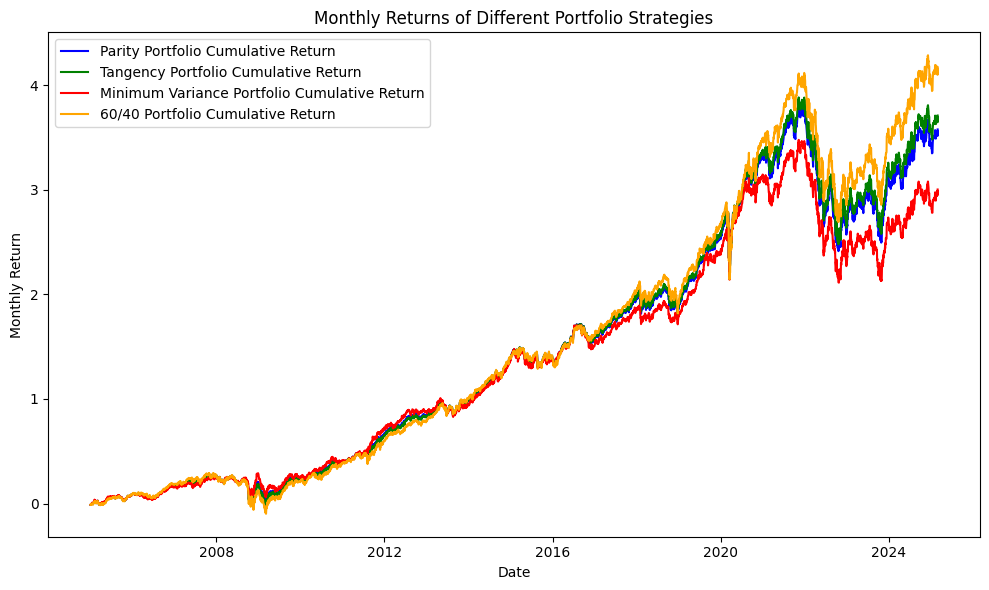

In [16]:
#.resample M is deprecated
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Vraag 2E
vti_monthly = vti.resample("M", on="Date").last()
tlt_monthly = tlt.resample("M", on="Date").last()

vti_monthly.loc[:, "Monthly_Return"] = vti_monthly["Adj Close"].pct_change()
tlt_monthly.loc[:, "Monthly_Return"] = tlt_monthly["Adj Close"].pct_change()

# 50 50 strategie of risk parity strategie    gebruikt wel nog daily returns
returns_df["Parity_Return"] = (returns_df["Return_VTI"] * 0.5 + returns_df["Return_TLT"] * 0.5)

#tangency portfolio
cov_matrix = returns_df[["Return_VTI", "Return_TLT"]].cov()
mean_returns = returns_df[["Return_VTI", "Return_TLT"]].mean()
sharpe_ratio = np.linalg.inv(cov_matrix).dot(mean_returns)  # Tangency

#gewichten in de tangency portfolio
tangency_weight_vti = sharpe_ratio[0] / (sharpe_ratio[0] + sharpe_ratio[1])  # VTI
tangency_weight_tlt = 1 - tangency_weight_vti  # TLT

# calculate de tangency return
returns_df["Tangency_Return"] = (returns_df["Return_VTI"] * tangency_weight_vti + returns_df["Return_TLT"] * tangency_weight_tlt)

# wiskunde
inv_cov_matrix = np.linalg.inv(cov_matrix)
ones = np.ones(len(mean_returns))
min_var_weights = inv_cov_matrix.dot(ones) / ones.dot(inv_cov_matrix).dot(ones)
min_var_weight_vti = min_var_weights[0]
min_var_weight_tlt = 1 - min_var_weight_vti

# minimum variantie returns
returns_df["Min_Variance_Return"] = (returns_df["Return_VTI"] * min_var_weight_vti + returns_df["Return_TLT"] * min_var_weight_tlt)

# 60 / 40 returns
returns_df["60_40_Return"] = (returns_df["Return_VTI"] * 0.6 + returns_df["Return_TLT"] * 0.4)

print(returns_df[["Date", "Parity_Return", "Tangency_Return", "Min_Variance_Return", "60_40_Return"]].head())

returns_df["Cumulative_Parity_Return"] = (1 + returns_df["Parity_Return"]).cumprod() - 1
returns_df["Cumulative_Tangency_Return"] = (1 + returns_df["Tangency_Return"]).cumprod() - 1
returns_df["Cumulative_Min_Variance_Return"] = (1 + returns_df["Min_Variance_Return"]).cumprod() - 1
returns_df["Cumulative_60_40_Return"] = (1 + returns_df["60_40_Return"]).cumprod() - 1

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(returns_df["Date"], returns_df["Cumulative_Parity_Return"], label="Parity Portfolio Cumulative Return", color="blue")
ax.plot(returns_df["Date"], returns_df["Cumulative_Tangency_Return"], label="Tangency Portfolio Cumulative Return", color="green")
ax.plot(returns_df["Date"], returns_df["Cumulative_Min_Variance_Return"], label="Minimum Variance Portfolio Cumulative Return", color="red")
ax.plot(returns_df["Date"], returns_df["Cumulative_60_40_Return"], label="60/40 Portfolio Cumulative Return", color="orange")

ax.set_title("Monthly Returns of Different Portfolio Strategies")
ax.set_xlabel("Date")
ax.set_ylabel("Monthly Return")
ax.legend()

plt.tight_layout()
plt.show()


# Vraag 2f
60/40 doet het het beste,
minimum variance het slechst

In [ ]:
# Vraag 2G
returns_train = returns_df[returns_df["Date"] >= "2007-01-01"]

# functie voor annualizing voor vraag 2H
def annualized_stats(df, return_column):
    annualized_mean = df[return_column].mean() * 252
    annualized_std = df[return_column].std() * np.sqrt(252)
    sharpe_ratio = annualized_mean / annualized_std
    return annualized_mean, annualized_std, sharpe_ratio

annualized_stats_dict = {
    "Parity": annualized_stats(returns_df, "Parity_Return"),
    "Tangency": annualized_stats(returns_df, "Tangency_Return"),
    "Min_Variance": annualized_stats(returns_df, "Min_Variance_Return"),
    "60_40": annualized_stats(returns_df, "60_40_Return"),
}

annualized_df = pd.DataFrame(annualized_stats_dict, index=["Annualized Mean", "Annualized Std", "Sharpe Ratio"])

print(annualized_df)

# lelijke plot

# fig, ax = plt.subplots(figsize=(10, 6))
# annualized_df.loc["Sharpe Ratio"].plot(kind="bar", ax=ax, color=["blue", "green", "red", "orange", "purple", "brown"])
# ax.set_title("Sharpe Ratios of Different Strategies")
# ax.set_ylabel("Sharpe Ratio")
# ax.set_xlabel("Portfolio/Asset")
# ax.set_xticklabels(annualized_df.columns, rotation=45, ha="right")
# plt.tight_layout()
# plt.show()


                   Parity  Tangency  Min_Variance     60_40
Annualized Mean  0.080685  0.082297      0.073655  0.087893
Annualized Std   0.100750  0.102589      0.097052  0.111440
Sharpe Ratio     0.800846  0.802208      0.758916  0.788703


# vraag 2H
De sharpe ratio van de minimum variance is het laags wat overeen komt met vraag 2F. de sharpe ratio van de tangency is het hoogst wat niet overeen komt met vraag 2F maar wat uitgelegd kan worden door de lagere returns maar ook een stuk lagere standaard deviatie dan de 60/40 die het in vraag 2F nog beter deed.

In [18]:
vti_price_end_feb = vti[vti["Date"] == "2025-02-28"]["Adj Close"].iloc[0]
tlt_price_end_feb = tlt[tlt["Date"] == "2025-02-28"]["Adj Close"].iloc[0]

portfolio_value = 100000
allocation_vti = portfolio_value * 0.5
allocation_tlt = portfolio_value * 0.5

shares_vti = int(allocation_vti // vti_price_end_feb)
shares_tlt = int(allocation_tlt // tlt_price_end_feb)

print(f"aandelen VTI: {shares_vti}")
print(f"bonds TLT: {shares_tlt}")

total_invested_vti = shares_vti * vti_price_end_feb
total_invested_tlt = shares_tlt * tlt_price_end_feb
print(f"Totaal VTI: {total_invested_vti}")
print(f"Totaal TLT: {total_invested_tlt}")
print(f"Totaal totaal: {total_invested_vti + total_invested_tlt}")

aandelen VTI: 170
bonds TLT: 542
Totaal VTI: 49803.19854736328
Totaal TLT: 49939.87966918945
Totaal totaal: 99743.07821655273


# Vraag 2 I
Je houd 170 shares in the VTI, 542 in de TLT. Wat uitkomt op 50k in beide wat in lijn is met de parity strategie